In [1]:
import psycopg2
import pandas as pd
import matplotlib.lines as mlines
import re
import datetime
import random
import nltk
import numpy as np

In [5]:
ADMISSIONS_df = pd.read_csv("ADMISSIONS.csv")
DIAGNOSES_ICD_df = pd.read_csv("DIAGNOSES_ICD.csv")

In [3]:
ADMISSIONS_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


### Organize ethnic groups into fewer groups 

In [4]:
ethnicity_df = ADMISSIONS_df["ETHNICITY"].copy()
ethnicity_df.replace(to_replace=' - [A-Z]*',value='',regex=True, inplace=True)
ethnicity_df.replace(to_replace='/[A-Z]*',value='',regex=True, inplace=True)
ethnicity_df.replace(to_replace=' [A-Z]*',value='',regex=True,inplace=True)
ethnicity_df.replace(to_replace=['UNKNOWN','UNABLE','PATIENT','MULTI','AMERICAN','PORTUGUESE','MIDDLE','NATIVE','HISPANIC(OTHER)','CARIBBEAN','SOUTH'],value='OTHER',inplace=True)
ethnicity_df.value_counts()

WHITE       41325
OTHER        7744
BLACK        5785
HISPANIC     2115
ASIAN        2007
Name: ETHNICITY, dtype: int64

### Clean up Diagnosis

In [6]:
diagnosis_df = ADMISSIONS_df["DIAGNOSIS"].copy()

In [7]:
diagnosis_df = diagnosis_df.to_frame()

In [8]:
diagnosis_df["D1"]='k'
diagnosis_df["D2"]='k'
diagnosis_df["D3"]='k'
diagnosis_df["D4"]='k'
diagnosis_df["D5"]='k'
diagnosis_df["D6"]='k'

In [9]:
for idx,row in enumerate(diagnosis_df.itertuples(),1):
    if type(row.DIAGNOSIS) == str:
        diag_list_semi = row.DIAGNOSIS.split(';')
        diag_list_back_slash = row.DIAGNOSIS.split('\\')
        if len(diag_list_back_slash) >= len(diag_list_semi):
                if len(diag_list_back_slash) == 1:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_back_slash[0]                   
                elif len(diag_list_back_slash) == 2:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)
                elif len(diag_list_back_slash) == 3:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)
                elif len(diag_list_back_slash) == 4:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[3]
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_back_slash)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)                   
                elif len(diag_list_back_slash) == 5:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_back_slash[4]
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_back_slash)
                elif len(diag_list_back_slash) == 6:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_back_slash[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_back_slash[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_back_slash[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_back_slash[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_back_slash[4]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_back_slash[5]           
        else:
                if len(diag_list_semi) == 1:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_semi[0]                   
                elif len(diag_list_semi) == 2:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 3:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 4:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[3]
                    diagnosis_df.at[row.Index,"D5"]=random.choice(diag_list_semi)
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 5:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_semi[4]
                    diagnosis_df.at[row.Index,"D6"]=random.choice(diag_list_semi)
                elif len(diag_list_semi) == 6:
                    diagnosis_df.at[row.Index,"D1"]=diag_list_semi[0]
                    diagnosis_df.at[row.Index,"D2"]=diag_list_semi[1]
                    diagnosis_df.at[row.Index,"D3"]=diag_list_semi[2]
                    diagnosis_df.at[row.Index,"D4"]=diag_list_semi[3]
                    diagnosis_df.at[row.Index,"D5"]=diag_list_semi[4]
                    diagnosis_df.at[row.Index,"D6"]=diag_list_semi[5]
    else:
        diagnosis_df.at[row.Index,"DIAGNOSIS"] = 'NONE'
        diagnosis_df.at[row.Index,"D1"]='NONE'
        diagnosis_df.at[row.Index,"D2"]='NONE'
        diagnosis_df.at[row.Index,"D3"]='NONE'
        diagnosis_df.at[row.Index,"D4"]='NONE'
        diagnosis_df.at[row.Index,"D5"]='NONE'
        diagnosis_df.at[row.Index,"D6"]='NONE'

In [10]:
diagnosis_df.head()

,DIAGNOSIS,D1,D2,D3,D4,D5,D6
0,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE,BENZODIAZEPINE OVERDOSE
1,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,CORONARY ARTERY DISEASE,CORONARY ARTERY BYPASS GRAFT/SDA,CORONARY ARTERY BYPASS GRAFT/SDA,CORONARY ARTERY DISEASE,CORONARY ARTERY BYPASS GRAFT/SDA,CORONARY ARTERY DISEASE
2,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS,BRAIN MASS
3,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION,INTERIOR MYOCARDIAL INFARCTION
4,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME,ACUTE CORONARY SYNDROME


## Get Patient vitals

In [12]:
df_temperatures = pd.read_csv("./temps/temperatures_trunc.csv",header=None)
df_temperatures.rename(columns={0:"SUBJECT_ID",1:"HADM_ID",2:"temperature_F"},inplace=True)
df_temperatures.drop_duplicates(subset=["SUBJECT_ID","HADM_ID"],inplace=True)
df_temperatures["temperature_F"] = df_temperatures["temperature_F"].round(2)

In [13]:
df_temperatures.head()

,SUBJECT_ID,HADM_ID,temperature_F
0,36,165660,97.3
1,34,144319,97.0
2,23,124321,98.4
31,85,112077,98.2
49,107,182383,97.6


In [14]:
df_heart_rate = pd.read_csv("./heart_rates/heart_rates_trunc.csv",header=None)
df_heart_rate.rename(columns={0:"SUBJECT_ID",1:"HADM_ID",2:"heart_rate_bps"},inplace=True)
df_heart_rate.drop_duplicates(subset=["SUBJECT_ID","HADM_ID"],inplace=True)
df_heart_rate.head()

,SUBJECT_ID,HADM_ID,heart_rate_bps
0,36,165660,86.0
4,34,144319,44.0
6,23,124321,85.0
141,85,112077,100.0
213,107,182383,73.0


In [25]:
# information used to create a database connection
sqluser = 'walter'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(host="localhost",dbname=dbname, user=sqluser, password="walters")


# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [26]:
query = query_schema + """
WITH co AS
(
SELECT adm.subject_id, adm.hadm_id
, adm.admittime - pat.dob AS age
FROM admissions adm
INNER JOIN patients pat
  ON adm.subject_id = pat.subject_id
)
SELECT
  co.subject_id, co.hadm_id, co.age
  , EXTRACT('year' FROM co.age) as age_extract_year 
  , EXTRACT('year' FROM co.age) 
    + EXTRACT('months' FROM co.age) / 12.0
    + EXTRACT('days' FROM co.age) / 365.242
    + EXTRACT('hours' FROM co.age) / 24.0 / 364.242
    as age_extract_precise
  , EXTRACT('epoch' from co.age) / 60.0 / 60.0 / 24.0 / 365.242 as age_extract_epoch
FROM co
"""
df_ages = pd.read_sql_query(query, con)


In [27]:
df_ages.drop(columns=["age","age_extract_year","age_extract_epoch"],inplace=True)
df_ages.rename(columns={"subject_id":"SUBJECT_ID","hadm_id":"HADM_ID"},inplace=True)

In [28]:
df_ages.head()

,SUBJECT_ID,HADM_ID,age_extract_precise
0,22,165315,64.928188
1,23,152223,71.131722
2,23,124321,75.256388
3,24,161859,39.017059
4,25,129635,58.950185


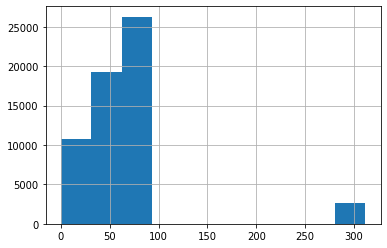

In [29]:
df_ages["age_extract_precise"].hist();

In [22]:
#use this line later to drop ages
#df_ages = df_ages[df_ages.age_extract_precise < 300.0]

### ADD AGES, TEMPERATURE, AND HEART RATE TO ADMISSIONS TABLE

In [31]:
admissions_copy = ADMISSIONS_df.copy()
admissions_copy.shape

(58976, 19)

In [32]:
admissions_copy = pd.merge(admissions_copy,df_ages,how='left',on=["SUBJECT_ID","HADM_ID"])
admissions_copy = pd.merge(admissions_copy,df_heart_rate,how='left',on=["SUBJECT_ID","HADM_ID"])
admissions_copy = pd.merge(admissions_copy,df_temperatures,how='left',on=["SUBJECT_ID","HADM_ID"])

In [33]:
admissions_copy.shape

(58976, 22)

In [34]:
admissions_copy["ETHNICITY"] = ethnicity_df

## ADD DIAGNOSES

In [35]:
admission_copy = pd.concat([admissions_copy,diagnosis_df[["D1","D2","D3","D4","D5","D6"]]],axis=1)

In [36]:
from sklearn.preprocessing import LabelBinarizer

In [37]:
#admission type
lb_style = LabelBinarizer()
lb_adm_type = lb_style.fit_transform(ADMISSIONS_df["ADMISSION_TYPE"])
adm_type = pd.DataFrame(lb_adm_type, columns=lb_style.classes_)
#admission location
lb_style = LabelBinarizer()
lb_adm_loc = lb_style.fit_transform(ADMISSIONS_df["ADMISSION_LOCATION"])
adm_loc = pd.DataFrame(lb_adm_loc, columns=lb_style.classes_)
#ethnicity
lb_style = LabelBinarizer()
lb_race = lb_style.fit_transform(ethnicity_df)
race = pd.DataFrame(lb_race, columns=lb_style.classes_)
#diagnosis
lb_style = LabelBinarizer()
lb_d1 = lb_style.fit_transform(diagnosis_df["D1"])
d1 =  pd.DataFrame(lb_d1, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d2 = lb_style.fit_transform(diagnosis_df["D2"])
#d2 =  pd.DataFrame(lb_d2, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d3 = lb_style.fit_transform(diagnosis_df["D3"])
#d3 =  pd.DataFrame(lb_d3, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d4 = lb_style.fit_transform(diagnosis_df["D4"])
#d4 =  pd.DataFrame(lb_d4, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d5 = lb_style.fit_transform(diagnosis_df["D5"])
#d5 =  pd.DataFrame(lb_d5, columns=lb_style.classes_)
#diagnosis
#lb_style = LabelBinarizer()
#lb_d6 = lb_style.fit_transform(diagnosis_df["D6"])
#d6 =  pd.DataFrame(lb_d6, columns=lb_style.classes_)

## Calculate length of stay

In [38]:
admissions_copy.insert(5,"LOS",0)

In [39]:
admissions_copy["ADMITTIME"] = pd.to_datetime(admissions_copy["ADMITTIME"])
admissions_copy["DISCHTIME"] = pd.to_datetime(admissions_copy["DISCHTIME"])
admissions_copy["LOS"] = admissions_copy["DISCHTIME"] - admissions_copy["ADMITTIME"]
admissions_copy["LOS"]=admissions_copy["LOS"].dt.total_seconds()/datetime.timedelta(days=1).total_seconds()

In [40]:
admissions_copy.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LOS,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,age_extract_precise,heart_rate_bps,temperature_F
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,...,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,64.928188,116.0,98.5
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,...,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,71.131722,94.0,98.1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,...,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,75.256388,85.0,98.4
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,...,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,39.017059,NaN,97.6
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,58.950185,70.0,97.0


## Add preliminary diagnoses

In [41]:
cdiff_pos_diagnosis=pd.read_csv("./data/cdiff_pos_trunc.csv",header=None)
cdiff_pos_diagnosis_list = cdiff_pos_diagnosis[0].tolist()
cdiff_pos_diagnosis_df = d1[cdiff_pos_diagnosis_list]
cdiff_pos_diagnosis_df.head()

,SEPSIS,PNEUMONIA,FEVER,CONGESTIVE HEART FAILURE,HYPOTENSION,ABDOMINAL PAIN,ALTERED MENTAL STATUS,COLITIS,PANCREATITIS,UPPER GI BLEED,...,HYPERKALEMIA,BOWEL OBSTRUCTION,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
admissions_diagnosis_df = pd.concat([admissions_copy[["SUBJECT_ID","HADM_ID","LOS"]],adm_type,adm_loc,race,admissions_copy[["age_extract_precise","heart_rate_bps","temperature_F"]],cdiff_pos_diagnosis_df],axis=1)

## REMOVE NEWBORNS

In [51]:
admissions_diagnosis_newborn_df = admissions_diagnosis_df[admissions_diagnosis_df.NEWBORN != 1]

## FIX AGES

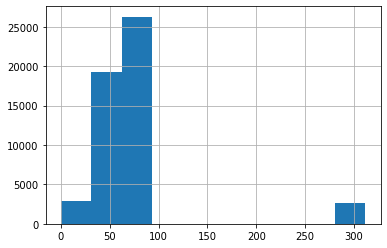

In [52]:
admissions_diagnosis_newborn_df["age_extract_precise"].hist();

In [53]:
#use this to drop ages corresponding to organ donors
admissions_diagnosis_newborn_df = admissions_diagnosis_newborn_df[admissions_diagnosis_newborn_df.age_extract_precise < 300.0]

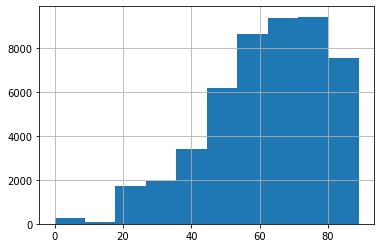

In [54]:
admissions_diagnosis_newborn_df["age_extract_precise"].hist();

In [65]:
for i in admissions_diagnosis_newborn_df["age_extract_precise"]:
    if np.isnan(i):
        print(i)
    elif i is None:
        print(i)

In [68]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,HYPERKALEMIA,BOWEL OBSTRUCTION,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA
58971,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
58972,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
58973,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58974,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
58975,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
admissions_diagnosis_newborn_df.reset_index(drop=True,inplace=True)

In [70]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,HYPERKALEMIA,BOWEL OBSTRUCTION,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA
48492,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
48493,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
48494,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48495,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
48496,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
df_temp_corrected = admissions_diagnosis_newborn_df["temperature_F"].fillna(98.6)

In [72]:
df_temp_corrected = df_temp_corrected.to_frame()

In [73]:
df_heart_rate_corrected = admissions_diagnosis_newborn_df["heart_rate_bps"].fillna(84.0)
df_heart_rate_corrected = df_heart_rate_corrected.to_frame()

In [75]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps
48492,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,99.1,123.0
48493,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,97.8,86.0
48494,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,99.0,120.0
48495,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,98.6,84.0
48496,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,98.2,113.0


### rename age_extract_precise and get rid of old temperature and heart rate

In [76]:
admissions_diagnosis_newborn_df.rename(columns={"age_extract_precise":"ages"},inplace=True)

In [78]:
admissions_diagnosis_newborn_df.drop(columns=["temperature_F","heart_rate_bps"],inplace=True)

In [79]:
admissions_diagnosis_newborn_df = pd.concat([admissions_diagnosis_newborn_df,df_temp_corrected,df_heart_rate_corrected],axis=1)

In [80]:
admissions_diagnosis_newborn_df.tail()

,SUBJECT_ID,HADM_ID,LOS,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,CELLULITIS,RENAL FAILURE,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps
48492,98800,191113,2.742361,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,99.1,123.0
48493,98802,101071,0.548611,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,97.8,86.0
48494,98805,122631,8.203472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,99.0,120.0
48495,98813,170407,41.445833,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,98.6,84.0
48496,98813,190264,1.607639,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,98.2,113.0


### Scale LOS, Ages, Temp, and Heart Rate

In [83]:
df_heart_rate = admissions_diagnosis_newborn_df["heart_rate_bps"].to_frame()

In [85]:
df_heart_rate.median()

heart_rate_bps    84.0
dtype: float64

In [96]:
df_heart_rate_scaled = (df_heart_rate - 84.0)/18.574

In [99]:
df_temperature = admissions_diagnosis_newborn_df["temperature_F"].to_frame()

In [100]:
df_temperature.median()

temperature_F    98.4
dtype: float64

In [101]:
df_temperature.std()

temperature_F    3.37459
dtype: float64

In [102]:
df_temperature_scaled = (df_temperature - 98.4)/3.3745

In [103]:
df_ages = admissions_diagnosis_newborn_df["ages"].to_frame()

In [104]:
df_ages.median()

ages    64.243139
dtype: float64

In [105]:
df_ages.std()

ages    17.133744
dtype: float64

In [106]:
df_ages_scaled = (df_ages - 64.243)/17.1337

In [107]:
df_los = admissions_diagnosis_newborn_df["LOS"].to_frame()

In [108]:
df_los.median()

LOS    6.90625
dtype: float64

In [109]:
df_los.std()

LOS    11.046324
dtype: float64

In [110]:
df_los_scaled = (df_los - 6.906)/11.04

In [111]:
admissions_scaled_features = admissions_diagnosis_newborn_df.copy()

In [112]:
admissions_scaled_features.drop(columns=["temperature_F","heart_rate_bps","ages","LOS"],inplace=True)

In [113]:
admissions_scaled_features = pd.concat([admissions_scaled_features,df_temperature_scaled,df_heart_rate_scaled,df_ages_scaled,df_los_scaled],axis=1)

In [114]:
admissions_scaled_features.tail()

,SUBJECT_ID,HADM_ID,ELECTIVE,EMERGENCY,NEWBORN,URGENT,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,...,CHOLECYSTITIS,LIVER FAILURE,BLUNT TRAUMA,ABDOMINAL AORTIC ANEURYSM,PANCREATIC MASS/SDA,ACUTE LEUKEMIA,temperature_F,heart_rate_bps,ages,LOS
48492,98800,191113,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.207438,2.099709,-2.617211,-0.377141
48493,98802,101071,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,-0.177804,0.107677,1.121229,-0.575850
48494,98805,122631,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.177804,1.938193,-1.267181,0.117525
48495,98813,170407,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.059268,0.000000,-0.202807,3.128608
48496,98813,190264,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,-0.059268,1.561322,-0.030540,-0.479924


In [115]:
ADMISSIONS_CDiff_pos_df = admissions_scaled_features.head(1).copy()
ADMISSIONS_CDiff_pos_df.drop([0],inplace=True)
ADMISSIONS_CDiff_neg_df = ADMISSIONS_CDiff_pos_df.copy()

for row in DIAGNOSES_ICD_df.itertuples():
    #C. Diff. has ICD9 Code 00845
    if row.ICD9_CODE == '00845':
        #print(row.SUBJECT_ID,row.HADM_ID,row.ICD9_CODE)
        subject_id = row.SUBJECT_ID
        hadm_id = row.HADM_ID
        ADMISSIONS_CDiff_pos_df = ADMISSIONS_CDiff_pos_df.append(admissions_scaled_features.loc[(admissions_scaled_features['SUBJECT_ID'] == subject_id) & (admissions_scaled_features['HADM_ID'] == hadm_id)])
        